# Water Mission, IBM

This Notebook offers analytics of water consumption for households in Busiro, Kikondo, and Dei districts of Uganda. It helps to create and update the monthly report from World Bank Data Project. You can find list of the report sections created using this notebook in _The Table of Content_ section below.

The Notebook processes the dataset from Uganda's districts. We assume, that dataset is a separate Excel file for each district. It should have at least 1 sheet with data named "Transaction log". 

To update the dataset you should add new Excel file into Oblect Storage and write its name into proper file container. 

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
 * [Common Figure Rendering Options](#rendering)
* [Data Pre-processing](#preprocessing)
 * [DataFrames Creation](#dataframes)
 * [Functions](#section3)
 * [Data preparation](#section4)
* [Report Data Calculation](#report)
 * [Section 1 - Water consumption analysis](#section1)
 * [Section 5 - Transactions Analysis](#section5)
 * [Section 6 - Renewal Amounts Analysis](#section6)


<a id="settings"></a>
# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

<a id="variables"></a>
## Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud. 

If you run the notebook on your local system set **environment** variable to **_local_** and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).

In [1]:
environment = 'bluemix'
root = 'c:\\sparknotes\\'
districts = ['Busiro', 'Kikondo', 'Dei', 'Chanhumba'] # Do not change
pattern = r'[a-z]' # Do not change

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [2]:
#@hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'Uganda Transaction logs.xlsx'
}

In [3]:
auth_url = credentials['auth_url']
container = credentials['container']
username = credentials['username']
domain_id = credentials['domain_id']
password= credentials['password']

<a id="imports"></a>
## Library Imports

In [4]:
import time
import math
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from operator import itemgetter
import pylab
from io import BytesIO
import requests
import json
import pandas as pd

from matplotlib import mlab
from __future__ import print_function
import calendar
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<a id="rendering"></a>
## Common Figure Rendering Options

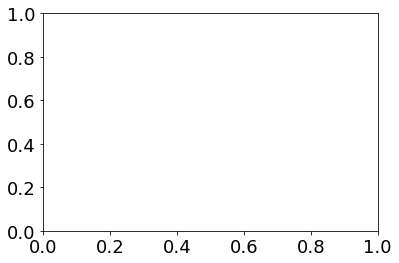

In [5]:
plt.rcParams.update({'font.size': 16})
plt.tick_params(axis='both', which='major', labelsize=18)
fig_size = plt.rcParams["figure.figsize"]
fig_size = [15, 7]
plt.rcParams["figure.figsize"] = fig_size

<a id="preprocessing"></a>
# Data Pre-processing
This section aggregates code to load data, definitions of functions used to pre-process data, and code to prepare data.

<a id="dataframes"></a>
## DataFrames Creation
In this section we load dataset file from and create DataFrame instances for the districts from corresponding tabs in the file.

In [6]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([auth_url, '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': username,'domain': {'id': domain_id},
            'password': password}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(container, filename, username, domain_id, password, auth_url)

The next section defines the dataset to be analyzed: for each site we define a list of files to be loaded and processed. When new data is available, add the files in the corresponding lists.

In [7]:
files_Chanhumba = ['Tanzania Transaction logs - Chanhumba.xlsx']
files_Busiro = ['Uganda Transaction logs - Busiro.xlsx']
files_Kikondo = ['Uganda Transaction logs - Kikondo.xlsx']
files_Dei = ['Uganda Transaction logs - Dei.xlsx']

sheet_name = 'Transaction log' # name of the tab, that contains transaction data

The _readFiles_ function loads files from the specified list and returns a single _DataFrame_ object with aggregated data.

In [8]:
def readFiles(files):
    frames = []
    for file in files:
        xls = pd.ExcelFile(get_file_content(file))
        frames.append(xls.parse(sheet_name))
    return pd.concat(frames)

In [9]:
waterUsageRDD_Kikondo = readFiles(files_Kikondo)
waterUsageRDD_Busiro = readFiles(files_Busiro)
waterUsageRDD_Dei = readFiles(files_Dei)
waterUsageRDD_Chanhumba = readFiles(files_Chanhumba)

<a id="section3"></a>
## Functions
This section defines functions used for data pre-processing.

In [10]:
# For section 5

def printTransactionEachRangeAllDistricts(districts):
    N = 13
    ind = np.arange(N)
    width = 0.2
    labels = []
    fig, ax = plt.subplots()
    
    for i in range(0, len(districts)):
        shift = 0
        districtColor = 'b'
        if (i > 0):
            shift += shift + i * width
            if (i == 1):
                districtColor = 'g'
            elif(i == 2):
                districtColor = 'r'
            else:
                districtColor = 'y'
        data = rf[rf.District == districts[i]]
        labels = ['0-25', '25-50', '50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-225', '225-250', '250-275', '275-300', '>300']
        data.Transaction_id = data.Transaction_id / data.Transaction_id.sum() * 100
        ax.bar(ind + shift, data.Transaction_id, width, color = districtColor) 
    ax.set_xlabel("Credit value")
    ax.set_ylabel("Percentage of total transactions")
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation=90, horizontalalignment='left')
    ax.legend(districts)
    plt.title('Total number transactions in each range')
    plt.margins(0.02)
    
def printDailyTransactionSumAllDistricts(districts):
    N = 13
    ind = np.arange(N)
    width = 0.2
    labels = []
    fig, ax = plt.subplots()
    for i in range(0, len(districts)):
        shift = 0
        districtColor = 'b'
        if (i > 0):
            shift += shift + i * width
            if (i == 1):
                districtColor = 'g'
            elif(i == 2):
                districtColor = 'r'
            else:
                districtColor = 'y'
        data = rf_byDay[rf_byDay.District == districts[i]]
        labels = ['0-25', '25-50', '50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-225', '225-250', '250-275', '275-300', '>300']
        data.Credits = data.Credits / data.Credits.sum() * 100
        ax.bar(ind + shift, data.Credits, width, color = districtColor) 
    ax.set_xlabel("Credit value")
    ax.set_ylabel("Percentage of total transactions")
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation=90, horizontalalignment='left')
    ax.legend(districts,loc = 2)
    plt.title('Summing up all daily transcations for each card')
    plt.margins(0.02)

#For section 6

def printRenewalAmountsAllDistricts(districts):
    N = 7
    ind = np.arange(N)
    width = 0.2
    labels = []
    fig, ax = plt.subplots()
    for i in range(0, len(districts)):
        shift = 0
        districtColor = 'b'
        if (i > 0):
            shift += shift + i * width
            if (i == 1):
                districtColor = 'g'
            elif(i == 2):
                districtColor = 'r'
            else:
                districtColor = 'y'
        data = rf_balanceRes[rf_balanceRes.District == districts[i]]
        labels = ['0-200', '200-400', '400-600', '600-800', '800-1000', '1000-1200', '>1200']
        data.Smartcard_1 = data.Smartcard_1 / data.Smartcard_1.sum() * 100
        ax.bar(ind + shift, data.Smartcard_1, width, color = districtColor) 
    ax.set_xlabel("Renew value")
    ax.set_ylabel("Percentage of total transactions")
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation=90, horizontalalignment='left')
    ax.legend(districts)
    plt.title('Renewal amounts analisys')
    plt.margins(0.02)

In [11]:
# get max interval between transactions (use for stopped cards determining)
def calculateInterval(card, district):
    percentage = 5
    data = cardsHistory[cardsHistory.District == district]
    cardData = data[data.Smartcard_1 == card]
    initAr = list(cardData.Date)
    ar = (len(initAr) - 1) * [0]
    for index in range(len(initAr) - 1):
        ar[index] = (initAr[index+1] - initAr[index]).days
    ar.sort()
    values = 2
    if(len(ar) * percentage / 100) > 2:
        values = int(round(len(ar) * percentage / 100) )
    if(values > len(ar)):
        values = len(ar)
    if(values  == 0):
        maxIntervalOfUsage = 0
    else:
        maxIntervalOfUsage = round(sum(ar[-values:])/values)
    if(maxIntervalOfUsage > 0):
        if(maxIntervalOfUsage < 30):
            maxIntervalOfUsage = 30
    
    return maxIntervalOfUsage

def getInterval(x):
    card = x[0] 
    district = x[1] 
    return calculateInterval(card, district)

def findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge):
    res = 'Running'
    if ((endDate - lastUsageDate).days > interval):
        if (float(lastBalance) > balanceLowerEdge):
            res = 'Stopped with credits'
        else:
            res = 'Stopped without credits'
    return res

# get card status: Running, stopped with credits or stopped without credits 
def getStatus(x):
    card = x[0] 
    district = x[1] 
    endDate = x[2]
    lastUsageDate = x[3]
    lastBalance = x[4]
    interval = x[5]
    return findStoppedCardsWithCredits(card, district, endDate, lastUsageDate, lastBalance, interval, balanceLowerEdge)

def getCardDataByDistrict(district):
    if(district == 'Busiro'):
        return waterUsageDF_Busiro
    if(district == 'Kikondo'):
        return waterUsageDF_Kikondo
    if(district == 'Dei'):
        return waterUsageDF_Dei
    if(district == 'Chanhumba'):
        return waterUsageDF_Chanhumba

# find how many times card was renewed, what is the average amount of deposit, min balance before deposit and average balance before deposit 
def getCreditInfoByDistrict(district):
    data = getCardDataByDistrict(district)    
    data.Balance = data.Balance.astype(float).fillna(0)
    data.Credits = data.Credits.astype(float).abs().fillna(0)
    d1 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Balance.min().reset_index()
    d2 = data.groupby(['Smartcard_1','Date', 'Date_and_time']).Credits.sum().reset_index()
    df = pd.merge(d1, d2, on = ['Smartcard_1','Date', 'Date_and_time'])
    df.Date_and_time = pd.to_datetime(df.Date_and_time)
    df = df.sort_values(['Smartcard_1','Date', 'Date_and_time'], ascending=[True, True, True])
    df['Balance_diff'] = df.groupby('Smartcard_1')['Balance'].diff().fillna(0)
    df = df[(df.Balance_diff > 0)]
    df.Credits = df.Credits + df.Balance_diff
    df['Balance_prev'] = df.Balance - df.Balance_diff
    prevMin = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].min()
    prevAve = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_prev'].mean()
    count = df[df.Balance_diff > 0].groupby('Smartcard_1')['Balance_diff'].count()
    ave = df[df.Balance_diff > 0].groupby('Smartcard_1')['Credits'].mean()
    result = pd.concat([count, ave, prevMin, prevAve], axis = 1).reset_index()
    result = result.fillna(0)
    result.columns = ['Smartcard_1', 'Credits_Add', 'Add_Credits_Mean', 'Balance_Before_Credit_Min', 'Balance_Before_Credit_Mean']
    return result

In [12]:
#  this function defines credit amount groups
def creditGroup(y):
    x = abs(y)
    if (x >= 0) & (x < 25):
        return 1
    if (x >= 25) & (x < 50):
        return 2
    if (x >= 50) & (x < 75):
        return 3
    if (x >= 75) & (x < 100):
        return 4
    if (x >= 100) & (x < 125):
        return 5
    if (x >= 125) & (x < 150):
        return 6
    if (x >= 150) & (x < 175):
        return 7
    if (x >= 175) & (x < 200):
        return 8
    if (x >= 200) & (x < 225):
        return 9
    if (x >= 225) & (x < 250):
        return 10
    if (x >= 250) & (x < 275):
        return 11
    if (x >= 275) & (x < 300):
        return 12
    if (x >= 300):
        return 13
  
    return 0

In [13]:
# this function defines credit renewal amount groups
def renewBalanceGroup(x):
    if (x >= 0) & (x < 200):
        return 1
    if (x >= 200) & (x < 400):
        return 2
    if (x >= 400) & (x < 600):
        return 3
    if (x >= 600) & (x < 800):
        return 4
    if (x >= 800) & (x < 1000):
        return 5
    if (x >= 1000) & (x < 1200):
        return 6
    if (x >= 1200):
        return 7
  
    return 0

<a id="section4"></a>
## Data preparation

Remove rows with empty 'Smartcard 1' values, drop duplicates, convert date and time, add district name

In [14]:
def cleanData(waterUsageDF, districtName):
    waterUsageDF = waterUsageDF[~waterUsageDF['Smartcard 1'].isnull()]
    if(waterUsageDF['Smartcard 1'].dtype != 'object'):
        waterUsageDF['Smartcard 1'] = waterUsageDF['Smartcard 1'].astype(int).astype(str)   
    waterUsageDF_2 = waterUsageDF[(waterUsageDF['Smartcard 1'].str.contains(pattern) != True) & (waterUsageDF['Smartcard 1'] != '')]
    waterUsageDF_2.columns = ['Transaction_id','Date_and_time','Dispenser','Operation','Smartcard_1','Smartcard_2','Water_dispensed','Credits','Balance','Total_created']
    waterUsageDF_2 = waterUsageDF_2.drop_duplicates().reset_index(drop=True)
    
    waterUsageDF_2.Date_and_time = pd.to_datetime(waterUsageDF_2.Date_and_time, format='%d-%m-%Y %H:%M:%S')
    waterUsageDF_2['Date'] = waterUsageDF_2.Date_and_time.dt.date
    waterUsageDF_2.Date = pd.to_datetime(waterUsageDF_2.Date, format='%Y-%m-%d')
    
    waterUsageDF_2['District'] = districtName
    
    return waterUsageDF_2

In [15]:
waterUsageDF_Busiro = cleanData(waterUsageRDD_Busiro, 'Busiro')
waterUsageDF_Kikondo = cleanData(waterUsageRDD_Kikondo, 'Kikondo')
waterUsageDF_Dei = cleanData(waterUsageRDD_Dei, 'Dei')
waterUsageDF_Chanhumba = cleanData(waterUsageRDD_Chanhumba, 'Chanhumba')

Let's move transactions for 'vendor' cards into a separate set, and remove them from the dataset

In [16]:
vendor_cards = {'1604', '1605', '2281', '2283', '2284', '2291', '2292', '2954'}
vendors = waterUsageDF_Kikondo[waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)] 
vendors = vendors.append(waterUsageDF_Busiro[waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)])

waterUsageDF_Busiro = waterUsageDF_Busiro[~waterUsageDF_Busiro["Smartcard_1"].isin(vendor_cards)] 
waterUsageDF_Kikondo = waterUsageDF_Kikondo[~waterUsageDF_Kikondo["Smartcard_1"].isin(vendor_cards)]

Save datasets with all types of operation for future

In [17]:
waterUsageDF_Busiro_allOperations = waterUsageDF_Busiro
waterUsageDF_Kikondo_allOperations = waterUsageDF_Kikondo
waterUsageDF_Dei_allOperations = waterUsageDF_Dei
waterUsageDF_Chanhumba_allOperations = waterUsageDF_Chanhumba

allOperations = waterUsageDF_Busiro_allOperations.append(waterUsageDF_Kikondo_allOperations).append(waterUsageDF_Dei).append(waterUsageDF_Chanhumba).append(vendors)
allOperations = allOperations[~allOperations.Smartcard_1.isnull()]

Let's remove from from the dataset all operations different to _Water dispensed_, and further clean the data

In [18]:
def cleanData2(waterUsageDF):
    waterUsageDF = waterUsageDF[(waterUsageDF.Operation == 'Water dispensed')]
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.replace(to_replace='.0', value='', regex=False)
    waterUsageDF.Smartcard_1 = waterUsageDF.Smartcard_1.astype(int).astype(str)
    waterUsageDF = waterUsageDF[(waterUsageDF.Smartcard_1 != '')]
    return waterUsageDF

In [19]:
waterUsageDF_Busiro = cleanData2(waterUsageDF_Busiro)
waterUsageDF_Kikondo = cleanData2(waterUsageDF_Kikondo)
waterUsageDF_Dei = cleanData2(waterUsageDF_Dei)
waterUsageDF_Chanhumba = cleanData2(waterUsageDF_Chanhumba)


Clean the aggregated data as well

In [20]:
allOperations.Smartcard_1 = allOperations.Smartcard_1.replace(to_replace='.0', value='', regex=False)
allOperations.Smartcard_2 = allOperations.Smartcard_2.replace(to_replace='.0', value='', regex=False)

allOperations.Smartcard_1 = allOperations.Smartcard_1.astype(int).astype(str)

allOperations = allOperations[(allOperations.Smartcard_1 != '')]

Prepare data related to credits

In [21]:
def prepareCreditsData(waterUsageDF, districtName):
    credits = getCreditInfoByDistrict(districtName)
    result = pd.merge(waterUsageDF, credits, on='Smartcard_1', how='left')
    result['District'] = districtName
    result['EndDate'] = waterUsageDF.Date.max()
    return result

busiroResult = prepareCreditsData(waterUsageDF_Busiro, 'Busiro')
kikondoResult = prepareCreditsData(waterUsageDF_Kikondo, 'Kikondo')
deiResult = prepareCreditsData(waterUsageDF_Dei, 'Dei')
chanhumbaResult = prepareCreditsData(waterUsageDF_Chanhumba, 'Chanhumba')

In [22]:
result = pd.DataFrame(busiroResult.append(kikondoResult).append(deiResult).append(chanhumbaResult), 
                columns=['Transaction_id','Date','Date_and_time','EndDate','District','Dispenser','Smartcard_1','Water_dispensed',
                'Credits','Balance','Credits_Add','Add_Credits_Mean','Balance_Before_Credit_Min','Balance_Before_Credit_Mean'])

transaction_Count = result.groupby(['District','Smartcard_1'])['Transaction_id'].count().reset_index()
water_dispensed_Mean = result.groupby(['District','Smartcard_1'])['Water_dispensed'].mean().reset_index()
first_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].min().reset_index()
last_Usage_Date = allOperations.groupby(['District','Smartcard_1'])['Date'].max().reset_index()

d1 = pd.merge(transaction_Count, water_dispensed_Mean, on=['District','Smartcard_1'], how='left')
d2 = pd.merge(first_Usage_Date, last_Usage_Date, on=['District','Smartcard_1'], how='left')
additionalDB = pd.merge(d1, d2, on=['District','Smartcard_1'], how='left')
additionalDB.columns = ['District', 'Smartcard_1', 'Transaction_Count', 'Water_dispensed_Mean', 'First_Usage_Date', 'Last_Usage_Date']
resultset = pd.merge(result, additionalDB, on=['District','Smartcard_1'], how='left')

In [23]:
cardData1 = allOperations.groupby(['District','Smartcard_1', 'Date']).Water_dispensed.sum()
cardData2 = allOperations.groupby(['District','Smartcard_1', 'Date']).Balance.min()
cardDataRes = pd.concat([cardData1, cardData2], axis = 1).reset_index()
cardsHistory = cardDataRes.sort_values(['District','Smartcard_1', 'Date'], ascending=[True,True,True]).reset_index(drop=True)

lastBalance = cardsHistory.groupby(['District','Smartcard_1']).Balance.last().reset_index()
lastBalance.columns = ['District','Smartcard_1','LastBalance']

cardsMaxInterval = pd.DataFrame(lastBalance, columns=['Smartcard_1', 'District'], index = lastBalance.index).drop_duplicates().reset_index(drop=True)
cardsMaxInterval.loc[:,'Interval'] = cardsMaxInterval.apply(getInterval, axis = 1)

resultset = pd.merge(resultset, lastBalance, on=['District','Smartcard_1'], how='left')
resultset = pd.merge(resultset, cardsMaxInterval, on=['District','Smartcard_1'], how='left')
resultset.LastBalance = resultset.LastBalance.astype(float)

balanceLowerEdge = 15

cardsStatus = pd.DataFrame(resultset, columns=['Smartcard_1', 'District', 'EndDate', 
                                               'Last_Usage_Date', 'LastBalance', 'Interval'], index = resultset.index).drop_duplicates().reset_index(drop=True)
cardsStatus.loc[:,'Status'] = cardsStatus.apply(getStatus, axis = 1)

In [24]:
resultset = pd.merge(resultset, cardsStatus, on=['Smartcard_1', 'District', 'EndDate', 'Last_Usage_Date', 'LastBalance', 'Interval'], how='left')
resultset.LastBalance = resultset.LastBalance.fillna(0)
resultset['CreditGroup'] = pd.Series(resultset.Credits, index=resultset.index).apply(creditGroup)

<a id="report"></a>
# Report Data Calculation

<a id="section1"></a>
## Section 1 - Water consumption analysis
Here we just calculate number of data entries for each district we analyze. 

In [25]:
# Dataset length:
print('Busiro size', len(waterUsageDF_Busiro_allOperations))
print('Kikondo size', len(waterUsageDF_Kikondo_allOperations))
print('Dei size', len(waterUsageDF_Dei_allOperations))
print('Chanhumba size', len(waterUsageDF_Chanhumba_allOperations))

Busiro size 173141
Kikondo size 149910
Dei size 53559
Chanhumba size 26968


<a id="section5"></a>
## Section 5 - Transactions Analysis

In [26]:
rf = resultset.pivot_table(
    values='Transaction_id', index=['District', 'CreditGroup'], aggfunc=lambda x: len(x), fill_value=0).reset_index()

creditGroupByDay = resultset.groupby(['District', 'Smartcard_1', 'Date']).Credits.sum().reset_index()
creditGroupByDay['CreditGroup'] = pd.Series(creditGroupByDay.Credits, index=creditGroupByDay.index).apply(creditGroup)
creditGroupByDay['Count'] = 1
rf_byDay = creditGroupByDay.pivot_table(
    values='Count', index=['District', 'CreditGroup'], aggfunc=np.sum, fill_value=0).reset_index()
rf_byDay.columns = ['District', 'CreditGroup', 'Credits']

rf_byDayRes = pd.concat([rf_byDay, rf], axis = 0).reset_index().fillna(0)
rf_byDayRes1 = rf_byDayRes.groupby(['District', 'CreditGroup']).Credits.sum()
rf_byDayRes2 = rf_byDayRes.groupby(['District', 'CreditGroup']).Transaction_id.sum()
rf_byDayRes = pd.concat([rf_byDayRes1, rf_byDayRes2], axis = 1).reset_index()
rf_byDayRes.columns = ['District', 'Group', 'TransactionsPerDay', 'TransactionsAll']

d = resultset.groupby(['District','Smartcard_1','Date', 'Date_and_time']).Balance.min().reset_index()
df_balance = d.sort_values(['District','Smartcard_1','Date', 'Date_and_time'], ascending=[True, True, True, True])
df_balance['Balance_diff'] = df_balance.groupby(['District','Smartcard_1'])['Balance'].diff()
df_balance['Balance_prev'] = df_balance.Balance - df_balance.Balance_diff

# groups by balance
df_clearBalance = df_balance[df_balance.Balance_diff > 0]
df_clearBalance['BalanceGroup'] = pd.Series(df_clearBalance.Balance_diff, index=df_clearBalance.index).apply(renewBalanceGroup)
rf_balanceRes = df_clearBalance.pivot_table(
    values='Smartcard_1', index=['District', 'BalanceGroup'], aggfunc=lambda x: len(x), fill_value=0).reset_index()

Next chart shows total number transactions in each range for all three locations:

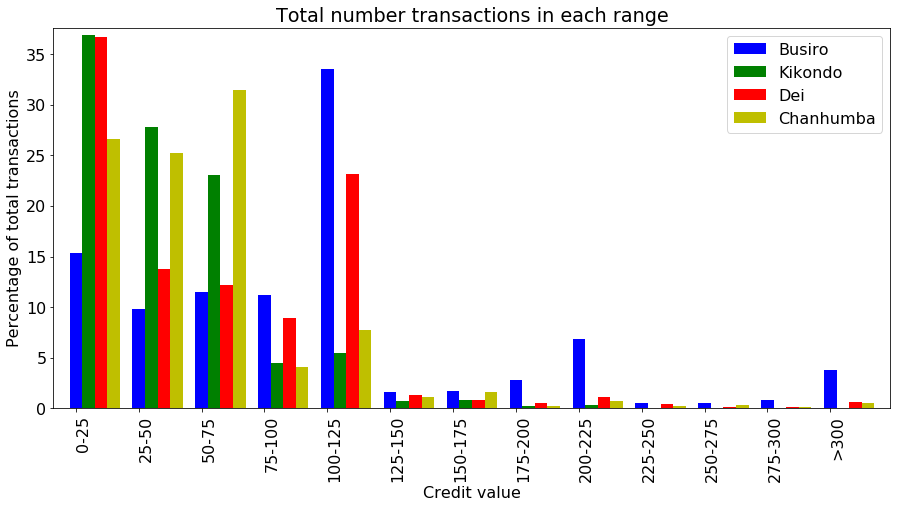

In [27]:
printTransactionEachRangeAllDistricts(districts)

Then we summing up all daily transcations for each card:

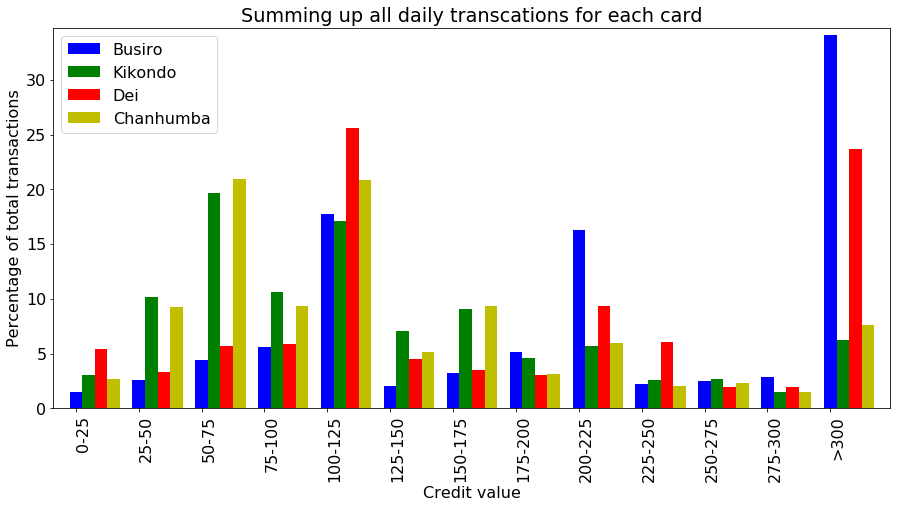

In [28]:
printDailyTransactionSumAllDistricts(districts)

In [29]:
# summary information by each card
summary_counts1 = resultset.groupby(['District', 'Smartcard_1', 'Date']).Credits.count()
summary_counts2 = resultset.groupby(['District', 'Smartcard_1', 'Date']).Credits.max()
summary_counts3 = resultset.groupby(['District', 'Smartcard_1', 'Date']).Credits.min()
summary_counts4 = resultset.groupby(['District', 'Smartcard_1', 'Date']).Credits.mean()
summary_counts5 = resultset.groupby(['District', 'Smartcard_1', 'Date']).Credits.sum()
summary_counts = pd.concat([summary_counts1, summary_counts2, summary_counts3, 
                            summary_counts4, summary_counts5], axis = 1).reset_index().sort_values([
    'District','Smartcard_1', 'Date'], ascending=[True, True, True])
summary_counts.columns = ['District', 'Smartcard_1', 'Date', 'Transactions_count', 'Credit_min', 'Credit_max', 'Credit_average', 'Credit_sum']
summary_counts.Credit_min = summary_counts.Credit_min.abs()
summary_counts.Credit_max = summary_counts.Credit_max.abs()
summary_counts.Credit_average = summary_counts.Credit_average.abs() 
summary_counts.Credit_sum = summary_counts.Credit_sum.abs() 

summary_counts['Month'] = pd.DatetimeIndex(summary_counts['Date']).month
sctc1 = summary_counts.groupby(['District', 'Smartcard_1', 'Month']).Transactions_count.sum()
sctc2 = summary_counts.groupby(['District', 'Smartcard_1', 'Month']).Transactions_count.count()
sctc = pd.concat([sctc1, sctc2], axis = 1).reset_index()
sctc.columns = ['District', 'Smartcard_1', 'Month', 'TransactionsByMonth', 'ActiveDaysInMonth']
sctcm1 = sctc.groupby(['District', 'Smartcard_1']).TransactionsByMonth.mean()
sctcm2 = sctc.groupby(['District', 'Smartcard_1']).ActiveDaysInMonth.mean()
sctcm = pd.concat([sctcm1, sctcm2], axis = 1).reset_index()
sctcm.columns = ['District', 'Smartcard_1', 'TransactionsByMonthAverage', 'ActiveDaysInMonthAverage']
sctc = pd.merge(sctc, sctcm, on=['District', 'Smartcard_1'])

summary_counts = pd.merge(summary_counts, sctc, on=['District', 'Smartcard_1', 'Month'])

We calculate average number of transactions per day:

In [30]:
print('Average number of transactions per day:')
print('Busiro', summary_counts[summary_counts.District == 'Busiro'].Transactions_count.mean())
print('Kikondo', summary_counts[summary_counts.District == 'Kikondo'].Transactions_count.mean())
print('Dei', summary_counts[summary_counts.District == 'Dei'].Transactions_count.mean())
print('Chanhumba', summary_counts[summary_counts.District == 'Chanhumba'].Transactions_count.mean())

Average number of transactions per day:
Busiro 2.7302704808548532
Kikondo 3.310523446019629
Dei 3.91181889971045
Chanhumba 2.8118313404657016


... and calculate average credits spent per day:

In [31]:
# Average number of credits per day:
print('Average number of credits per day:')
print('Busiro', summary_counts[summary_counts.District == 'Busiro'].Credit_average.mean())
print('Kikondo', summary_counts[summary_counts.District == 'Kikondo'].Credit_average.mean())
print('Dei', summary_counts[summary_counts.District == 'Dei'].Credit_average.mean())
print('Chanhumba', summary_counts[summary_counts.District == 'Chanhumba'].Credit_average.mean())


Average number of credits per day:
Busiro 116.73161663334552
Kikondo 49.960490615854866
Dei 70.75479095133467
Chanhumba 58.61933957962374


<a id="section6"></a>
# Section 6 - Renewal Amounts Analysis
The next picture shows balance renewal amount split into several ranges for all three locations:

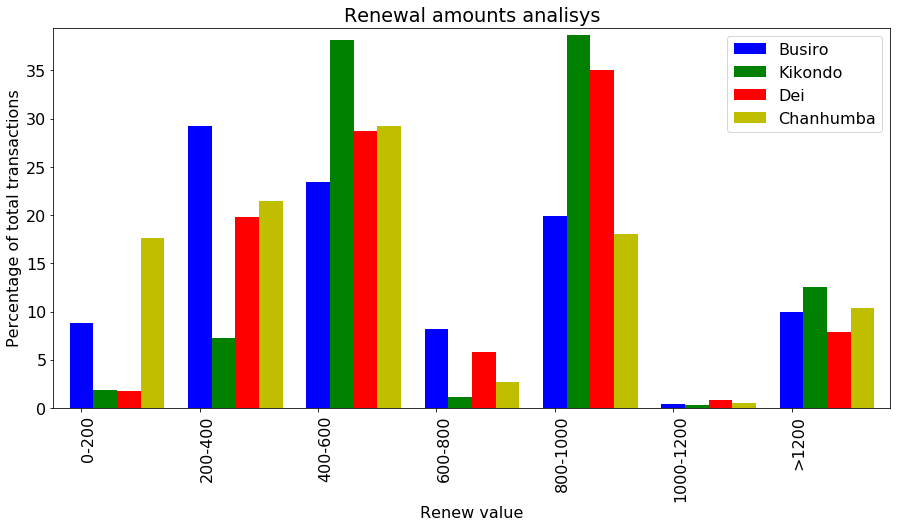

In [32]:
printRenewalAmountsAllDistricts(districts)

In [33]:
# calculating the average amount of water dispensed per unique card a day
resultset[(resultset.District == 'Chanhumba')].groupby(['Date', 'Smartcard_1']).Water_dispensed.sum().mean()

56.80190895741554